In [1]:
import pandas as pd 
import numpy as np
import cv2
import torch
import os
import glob
import re
import tensorflow as tf
from retinaface import RetinaFace
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms

import torchmetrics
import pytorch_lightning as pl
from tqdm import tqdm
import matplotlib.pyplot as plt

2022-10-11 14:52:32.540987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-11 14:52:33.100257: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-11 14:52:34.424786: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/silver22/.local/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.7/lib64
2022-10-11 14:52:34.424926: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic lib

#Формируем датасет Самых Доминантных Персон

In [2]:
annot_data = pd.read_csv('dome_annotations_M1.csv')
dome_dataset = pd.read_csv('dome_dataset_M1.csv')
dome_dataset
annot_data = annot_data.join(dome_dataset['FMD'])
annot_data = annot_data.join(dome_dataset['FLD'])
annot_data = annot_data.drop(annot_data[annot_data.FMD == 0].index)
annot_data

,name,start (sec),end (sec),A11,A12,A13,A14,A21,A22,A23,A24,A31,A32,A33,A34,FMD,FLD
0,IS1000a,0,300,4,1,3,2,4,1,3,2,4,1,3,2,1,1
1,IS1000a,300,600,3,1,4,2,3,1,4,2,3,1,4,2,1,1
2,IS1000a,600,900,1,4,2,3,1,2,4,3,1,4,3,2,1,0
4,IS1000a,1200,1500,4,1,3,2,3,1,4,2,3,1,4,2,1,0
6,IS1001a,300,600,1,2,4,3,1,2,4,3,1,2,4,3,1,1
7,IS1001a,600,900,1,2,3,4,1,2,3,4,1,2,3,4,1,1
9,IS1001b,300,600,1,3,4,2,1,2,4,3,1,2,4,3,1,1
12,IS1001b,1200,1500,1,2,3,4,1,3,2,4,1,2,3,4,1,1
13,IS1001b,1500,1800,1,3,2,4,1,2,3,4,1,2,3,4,1,1
14,IS1001b,1800,2100,1,2,3,4,1,2,3,4,1,2,3,4,1,1


In [3]:
set_of_video = ['IS1000a','IS1001a','IS1001b','IS1001c','IS1003b','IS1003d','IS1006b','IS1008a',
                'IS1008b','IS1008c','IS1008d']

In [73]:
for i in set_of_video:
    os.mkdir(f"NewImages/{i}")

#Получаем кадры из видео 

In [74]:
for name_video_folder in set_of_video:
  part_data = annot_data.loc[annot_data['name'] == name_video_folder]
  len_of_data = len(part_data)
  start_time = part_data['start (sec)'].values * 25 #number of frames
  end_time = part_data['end (sec)'].values * 25
  for number_person in range(0,4):
    vidcap = cv2.VideoCapture(f'amicorpus/{name_video_folder}/video/{name_video_folder}.Closeup{number_person+1}.avi')
    success,image = vidcap.read()
    count = 0
    index = 0
    bin_count = 0
    time_frames = 0
    while success:
      temp_data = part_data.iloc[index].values[3:7].tolist()
      dom_persone = temp_data.index(1)
      if count % 5 == 0 and count >= start_time[index] and count <= end_time[index] :
        #print(count)
        if count % 1500 == 0:
          time_frames = int(count / 1500)
          dir1 = os.path.join("NewImages/", f"{name_video_folder}", f"{time_frames}min_domperson{dom_persone}")
          if not os.path.exists(dir1):
            os.mkdir(dir1)
        dir2 = os.path.join(f"NewImages/{name_video_folder}", f"{time_frames}min_domperson{dom_persone}", f"person{number_person}")
        if not os.path.exists(dir2):
          bin_count = 0
          os.mkdir(dir2)
        bin_count_txt = f'{bin_count:0012b}'
        cv2.imwrite(f"NewImages/{name_video_folder}/{time_frames}min_domperson{dom_persone}/person{number_person}/{bin_count_txt}.jpg", image)
        bin_count += 1
      success,image = vidcap.read()
      #print(count," ",dom_persone)
      if count >= end_time[index] - 1 and len_of_data-1 > index:
        index += 1
      count += 1

[mpeg4 @ 0x5634a4907cc0] ac-tex damaged at 20 11
[mpeg4 @ 0x5634a4907cc0] Error at MB: 273
[mpeg4 @ 0x5634a4907cc0] marker does not match f_code
[mpeg4 @ 0x5634a4907cc0] marker does not match f_code
[mpeg4 @ 0x5634a4907cc0] marker does not match f_code
[mpeg4 @ 0x5634a4907cc0] marker does not match f_code
[mpeg4 @ 0x5634a4907cc0] marker does not match f_code
[mpeg4 @ 0x5634a4907cc0] marker does not match f_code
[mpeg4 @ 0x5634a4907cc0] marker does not match f_code
[mpeg4 @ 0x5634a4907cc0] marker does not match f_code
[mpeg4 @ 0x5634a4907cc0] marker does not match f_code
[mpeg4 @ 0x5634a4907cc0] marker does not match f_code
[mpeg4 @ 0x5634a4907cc0] marker does not match f_code
[mpeg4 @ 0x5634a4907cc0] marker does not match f_code
[mpeg4 @ 0x5634a4907cc0] marker does not match f_code
[mpeg4 @ 0x5634a4907cc0] marker does not match f_code
[mpeg4 @ 0x5634a4907cc0] marker does not match f_code
[mpeg4 @ 0x5634a4907cc0] marker does not match f_code
[mpeg4 @ 0x5634a4907cc0] marker does not matc

In [89]:
list_of_files = glob.glob('NewImages/*')
for i in list_of_files:
    list_of_files2 = glob.glob(f"{i}/*")
    for j in list_of_files2:
       list_of_files3 = glob.glob(f"{j}/*") 
       for k in list_of_files3:
        list_of_files4 = glob.glob(f"{k}/*")
        if len(list_of_files4) != 300:
            print(list_of_files4)
            print("not ok")


In [88]:
os.mkdir('test5/lol')

FileNotFoundError: [Errno 2] No such file or directory: 'test5/lol'

In [100]:
for name_video_folder in set_of_video:
    list_of_files = glob.glob(f'NewImages/{name_video_folder}/*')
    for files in list_of_files:
        dir_1 = f'Face_Dominant128x128/{files[10:]}'
        if not os.path.exists(dir_1):
            os.mkdir(dir_1)
        for number_person in range(0,4):
            dir_2 = f'Face_Dominant128x128/{files[10:]}/person{number_person}'
            if not os.path.exists(dir_2):
                os.mkdir(dir_2)
            
            list_of_images = glob.glob(f'{files}/person{number_person}/*')
            for image_file in tqdm(list_of_images):
                faces = RetinaFace.extract_faces(img_path = image_file, align = False)
                if faces:
                    img_res = cv2.resize(faces[0],(128,128))
                    cv2.imwrite(f'Face_Dominant128x128/{image_file[10:]}',cv2.cvtColor(img_res, cv2.COLOR_BGR2GRAY))
                else:
                    black_image = np.zeros((128,128,1), np.uint8)
                    cv2.imwrite(f'Face_Dominant128x128/{image_file[10:]}',black_image)

    

100%|██████████| 300/300 [00:35<00:00,  8.50it/s]


In [14]:
list_of_images = glob.glob(f'Face_Dominant128x128/IS1008d/*')
list_of_images
for i in list_of_images:
    print(i[29:], end=' ')

10min_domperson3 11min_domperson3 12min_domperson3 13min_domperson3 14min_domperson3 20min_domperson1 21min_domperson1 22min_domperson1 23min_domperson1 

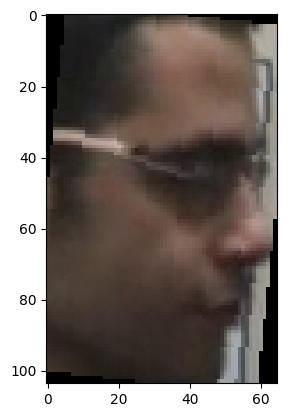

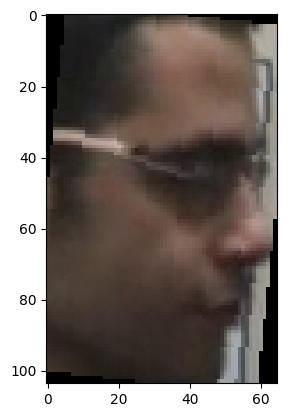

In [80]:
faces = RetinaFace.extract_faces(img_path = "/mnt/c/Users/shemetov/Desktop/DominantP/NewImages/IS1001a/5min_domperson0/person1/000000100110.jpg", align = True)
for face in faces:
  plt.imshow(faces[0])
  plt.show()